In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.7MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 1.0MB 17.3MB/s 
     |████████████████████████████████| 358kB 38.3MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 40kB 6.0MB/s 
     |████████████████████████████████| 92kB 11.1MB/s 
     |████████████████████████████████| 40kB 4.9MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 2.6MB 38.9MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *
import os
os.mkdir('images')

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'ef9f4f70e65540d1b206c7e99d4e02e5')

In [4]:
search_images_bing

<function fastbook.search_images_bing>

In [5]:
results = search_images_bing(key, 'simba')
ims = results.attrgot('content_url')
len(ims)

150

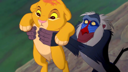

In [6]:
dest = 'images/simba.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [7]:
lion_types = 'lion','lioness','simba'
path = Path('lions')

In [8]:
def download_image_inner_mine(dest, inp, timeout=4):
    i,url = inp
    suffix = re.findall(r'\.\w+?(?=(?:\?|$))', url)
    suffix = suffix[0] if len(suffix)>0  else '.jpg'
    try: download_url(url, dest/f"{i:08d}{suffix}", overwrite=True, show_progress=False, timeout=timeout)
    except Exception as e: f"Couldn't download {url}."
def download_images_mine(dest, urls):
  dest = Path(dest)
  dest.mkdir(exist_ok=True)
  for i, url in enumerate(urls):
    download_image_inner_mine( dest, [i, url], timeout=4)

if not path.exists():
    path.mkdir()
    for o in lion_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        print(f'{o}')
        download_images_mine(dest, urls=results.attrgot('content_url'))

lion
lioness
simba


In [9]:
fns = get_image_files(path)
fns

(#448) [Path('lions/lion/00000036.jpg'),Path('lions/lion/00000054.jpg'),Path('lions/lion/00000108.jpg'),Path('lions/lion/00000126.JPG'),Path('lions/lion/00000028.jpg'),Path('lions/lion/00000021.jpg'),Path('lions/lion/00000127.jpg'),Path('lions/lion/00000019.jpg'),Path('lions/lion/00000111.jpg'),Path('lions/lion/00000059.jpg')...]

In [10]:
[fn.unlink() for fn in fns if not verify_image(fn)]

[None, None, None, None, None, None]

In [11]:
lions = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [12]:
dls = lions.dataloaders(path)

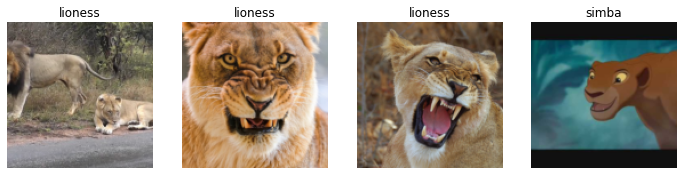

In [13]:
dls.valid.show_batch(max_n=4, nrows=1)

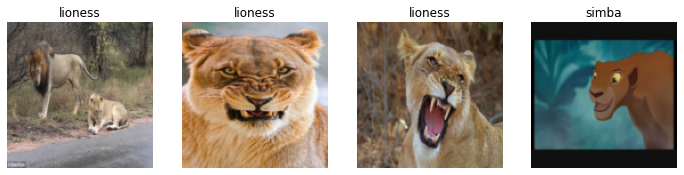

In [14]:
lions = lions.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = lions.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

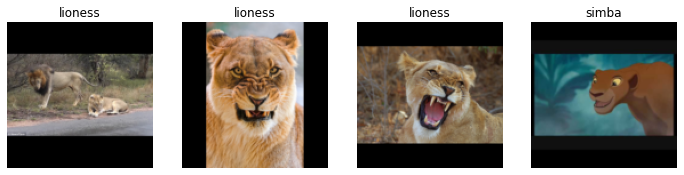

In [15]:
lions = lions.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = lions.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

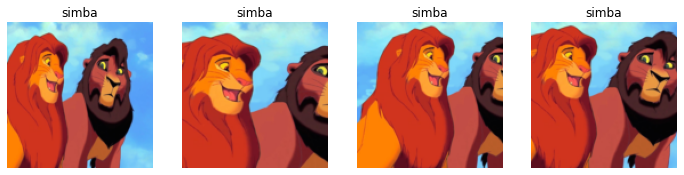

In [16]:
lions = lions.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = lions.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

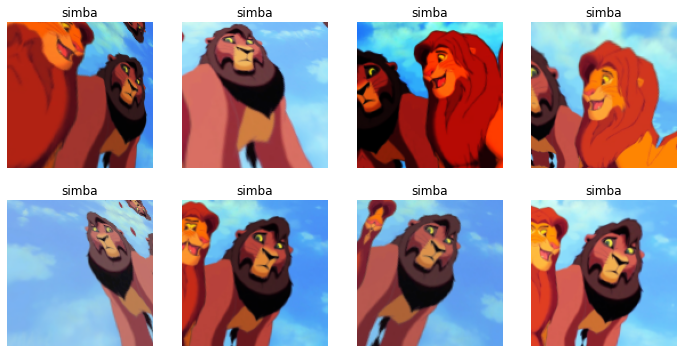

In [17]:
lions = lions.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = lions.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [18]:
lions = lions.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = lions.dataloaders(path)

In [19]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.691621,1.041520,0.318182,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.849894,0.852116,0.295455,00:10
1,0.781814,0.923795,0.295455,00:10
2,0.693673,0.879537,0.295455,00:10
3,0.628638,0.881299,0.306818,00:10


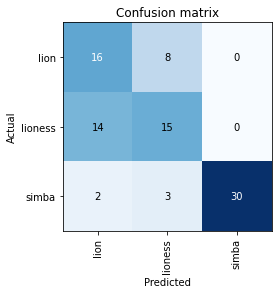

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

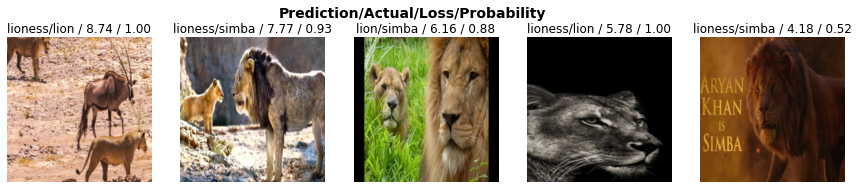

In [21]:
interp.plot_top_losses(5, nrows=1)

In [22]:
@patch
def __getitem__(self:Box, i): return self.children[i]

# Cell
def widget(im, *args, **layout):
    "Convert anything that can be `display`ed by IPython into a widget"
    o = Output(layout=merge(*args, layout))
    with o: display(im)
    return o

# Cell
def _update_children(change):
    for o in change['owner'].children:
        if not o.layout.flex: o.layout.flex = '0 0 auto'

# Cell
def carousel(children=(), **layout):
    "A horizontally scrolling carousel"
    def_layout = dict(overflow='scroll hidden', flex_flow='row', display='flex')
    res = Box([], layout=merge(def_layout, layout))
    res.observe(_update_children, names='children')
    res.children = children
    return res

# Cell
def _open_thumb(fn, h, w): return Image.open(fn).to_thumb(h, w).convert('RGBA')

def _get_iw_info(learn, ds_idx=0):
    dl = learn.dls[ds_idx].new(shuffle=False, drop_last=False)
    inp,probs,targs,preds,losses = learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True)
    inp,targs = L(zip(*dl.decode_batch((inp,targs), max_n=9999)))
    return L([dl.dataset.items,targs,losses]).zip()
class ImagesCleaner:
    "A widget that displays all images in `fns` along with a `Dropdown`"
    def __init__(self, opts=(), height=128, width=256, max_n=30):
        opts = ('<Keep>', '<Delete>')+tuple(opts)
        store_attr('opts,height,width,max_n')
        self.widget = carousel(width='100%')

    def set_fns(self, fns):
        self.fns = L(fns)[:self.max_n]
        ims = [_open_thumb(fn, self.height, self.width) for fn in  self.fns]
        self.widget.children = [VBox([widget(im, height=f'{self.height}px'), Dropdown(
            options=self.opts, layout={'width': 'max-content'})]) for im in ims]

    def _ipython_display_(self): display(self.widget)
    def values(self): return L(self.widget.children).itemgot(1).attrgot('value')
    def delete(self): return self.values().argwhere(eq('<Delete>'))
    def change(self):
        idxs = self.values().argwhere(negate_func(in_(['<Delete>','<Keep>'])))
        return idxs.zipwith(self.values()[idxs])
@delegates(ImagesCleaner)
class ImageClassifierCleaner(GetAttr):
    "A widget that provides an `ImagesCleaner` with a CNN `Learner`"
    def __init__(self, learn, **kwargs):
        vocab = learn.dls.vocab
        self.default = self.iw = ImagesCleaner(vocab, **kwargs)
        self.dd_cats = Dropdown(options=vocab)
        self.dd_ds   = Dropdown(options=('Train','Valid'))
        self.iwis = _get_iw_info(learn,0),_get_iw_info(learn,1)
        self.dd_ds.observe(self.on_change_ds, 'value')
        self.dd_cats.observe(self.on_change_ds, 'value')
        self.on_change_ds()
        self.widget = VBox([self.dd_cats, self.dd_ds, self.iw.widget])

    def _ipython_display_(self): display(self.widget)
    def on_change_ds(self, change=None):
        info = L(o for o in self.iwis[self.dd_ds.index] if o[1]==self.dd_cats.value)
        self.iw.set_fns(info.sorted(2, reverse=True).itemgot(0))

In [23]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [24]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [25]:
learn.export()

In [58]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [27]:
learn_inf = load_learner(path/'export.pkl')

In [29]:
learn_inf.predict('images/simba.jpg')

('simba', tensor(2), tensor([7.2054e-06, 8.1513e-05, 9.9991e-01]))

In [30]:
learn_inf.dls.vocab

(#3) ['lion','lioness','simba']

Creating a Notebook App from the model


In [62]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [63]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/simba.jpg'])

In [64]:
img = PILImage.create(btn_upload.data[-1])

In [65]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [66]:
pred,pred_idx,probs = learn_inf.predict(img)

In [67]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: simba; Probability: 0.9999')

In [68]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [69]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [70]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [71]:
VBox([widgets.Label('Select your photo!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [60]:
# from google.colab import files
# files.download('export.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Turning the Notebook into Real App

In [72]:
#hide
!pip install voila
!jupyter serverextension enable voila —sys-prefix

     |████████████████████████████████| 6.9MB 6.0MB/s 
     |████████████████████████████████| 153kB 42.0MB/s 
     |████████████████████████████████| 112kB 41.6MB/s 
     |████████████████████████████████| 512kB 42.2MB/s 
ERROR: nbdev 1.0.18 has requirement nbconvert<6, but you'll have nbconvert 6.0.5 which is incompatible.
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


Enabling: voila
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
Enabling: —sys-prefix
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension —sys-prefix
      X is —sys-prefix importable?
